# As TestingAndDevelopment.ipynb, but for small numbers and poisson-process assumptions

In [92]:
import numpy as np 
import pandas as pd

import ExcessMortalityFunctions as emf
from importlib import reload
reload(emf)

from scipy.stats import poisson

import matplotlib.pyplot as plt

%matplotlib widget

# import sys
 
# # setting path
# sys.path.append('../Functions')
# import PandemiXSignaturesForSubfolders as ps


# Generate data to use

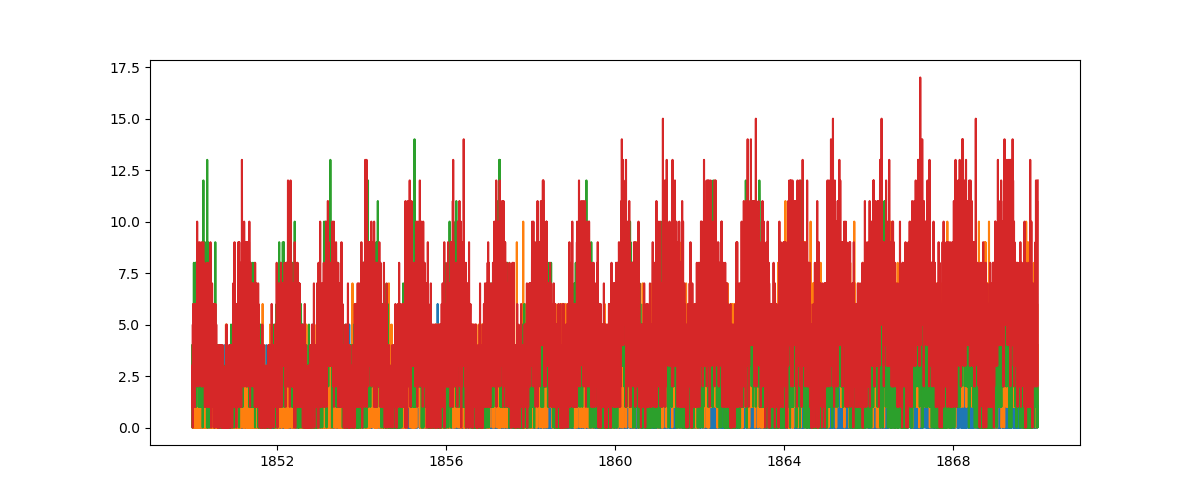

In [38]:
# Generate some data for testing
d1 = np.datetime64('1850-01-01')
d2 = np.datetime64('1870-01-01')
ts = np.arange(d1,d2)

# Constant
curMean = 1
curBase = poisson.rvs(curMean,size = len(ts))
curBaseConstant = curMean * np.ones(len(ts))

# Linearly increasing
curMean2 = 4
allMeans = np.linspace(curMean,curMean2,len(ts))
curBase2 = poisson.rvs(allMeans,size = len(ts))

# Sinusoidal
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 2
sinPer = 2*np.pi/365.25
curSin = sinAmp * np.sin(tDays * sinPer) + sinAmp + curMean 
curBase3 = poisson.rvs(curSin,size = len(ts))


# Sinusoidal and linear
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 2
sinPer = 2*np.pi/365.25
curSin = sinAmp * np.sin(tDays * sinPer) + sinAmp + allMeans
curBase4 = poisson.rvs(curSin,size = len(ts))

# Plot
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(ts,curBase)
ax.plot(ts,curBase2)
ax.plot(ts,curBase3)
ax.plot(ts,curBase4)


In [39]:

df = pd.DataFrame(
    index = ts,
    data={
        'Constant':curBaseConstant,
        'Base':curBase,
        'Base2':curBase2,
        'Base3':curBase3,
        'Base4':curBase4,
        }
)

# Some basic tests

In [347]:
# Add some random high values
dfOut = df.copy()

len(dfOut)
# indexToIncrease = np.random.randint(0,len(dfOut),100)
indexToIncrease = np.random.randint(0,len(dfOut),50)

# dfOut.iloc[indexToIncrease,:] = dfOut.iloc[indexToIncrease,:]*8
dfOut.iloc[indexToIncrease,:] = dfOut.iloc[indexToIncrease,:] + 15
# dfOut.iloc[indexToIncrease,:] = 20
# dfOut.iloc[indexToIncrease]

In [348]:
# dfOut

In [357]:
numYears = 5
# curData = dfOut.Constant
# curData = df.Base4
# curData = dfOut.Base3
# curData = dfOut.Base2
curData = dfOut.Base4
# curData = dfOut.Constant

In [358]:
# curDataRaw = curData.copy()
# curData = curData.rolling(window=7,center=True).mean()

In [359]:

# Add columns for year, month and day
curFrame = curData.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=curData.name,columns=['Month','Day'],index='Year')

# curPivot.head()

In [360]:

# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum() # Get sum of all values in roll
curCount = curRolling.count() # Count how many values were used in sum (to avoid counting NaN's)

curMean = (curSum - curPivot.fillna(0))/(curCount-curPivot.notna()*1)
curMean

curSF = pd.DataFrame(poisson.logsf(curPivot,curMean),columns=curPivot.columns,index=curPivot.index)
# curMean.shape

# curPivot.apply()
# curPivot
# curSF



In [361]:

curBot1,curTop1 = poisson.interval(0.5,curMean)
curBot2,curTop2 = poisson.interval(0.75,curMean)
curBot3,curTop3 = poisson.interval(0.95,curMean)

curBot1 = pd.DataFrame(curBot1,columns=curPivot.columns,index=curPivot.index)
curBot2 = pd.DataFrame(curBot2,columns=curPivot.columns,index=curPivot.index)
curBot3 = pd.DataFrame(curBot3,columns=curPivot.columns,index=curPivot.index)
curTop1 = pd.DataFrame(curTop1,columns=curPivot.columns,index=curPivot.index)
curTop2 = pd.DataFrame(curTop2,columns=curPivot.columns,index=curPivot.index)
curTop3 = pd.DataFrame(curTop3,columns=curPivot.columns,index=curPivot.index)
# poisson.ppf(0.75,curMean[1][1])
# curMean[1][1]


In [362]:
def reshapePivot(pivotTable):
        
    pivotTable = pivotTable.reset_index().melt(id_vars='Year') # Melt pivottable
    pivotTable['Date'] = pd.to_datetime(dict(year=pivotTable.Year,month=pivotTable.Month,day=pivotTable.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
    pivotTable = pivotTable.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
    pivotTable = pivotTable.loc[pivotTable.index.notna()] # Remove invalid dates (leap-days in not leap-years)

    return pivotTable

In [363]:

# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)

curSF = curSF.reset_index().melt(id_vars='Year') # Melt pivottable
curSF['Date'] = pd.to_datetime(dict(year=curSF.Year,month=curSF.Month,day=curSF.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curSF = curSF.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
curSF = curSF.loc[curSF.index.notna()] # Remove invalid dates (leap-days in not leap-years)

# curBot1 = curBot1.reset_index().melt(id_vars='Year') # Melt pivottable
# curBot1['Date'] = pd.to_datetime(dict(year=curBot1.Year,month=curBot1.Month,day=curBot1.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curBot1 = curBot1.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
# curBot1 = curBot1.loc[curBot1.index.notna()] # Remove invalid dates (leap-days in not leap-years)

# curTop1 = curTop1.reset_index().melt(id_vars='Year') # Melt pivottable
# curTop1['Date'] = pd.to_datetime(dict(year=curTop1.Year,month=curTop1.Month,day=curTop1.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curTop1 = curTop1.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
# curTop1 = curTop1.loc[curTop1.index.notna()] # Remove invalid dates (leap-days in not leap-years)

 
curBot1 = reshapePivot(curBot1)
curBot2 = reshapePivot(curBot2)
curBot3 = reshapePivot(curBot3)
curTop1 = reshapePivot(curTop1)
curTop2 = reshapePivot(curTop2)
curTop3 = reshapePivot(curTop3)

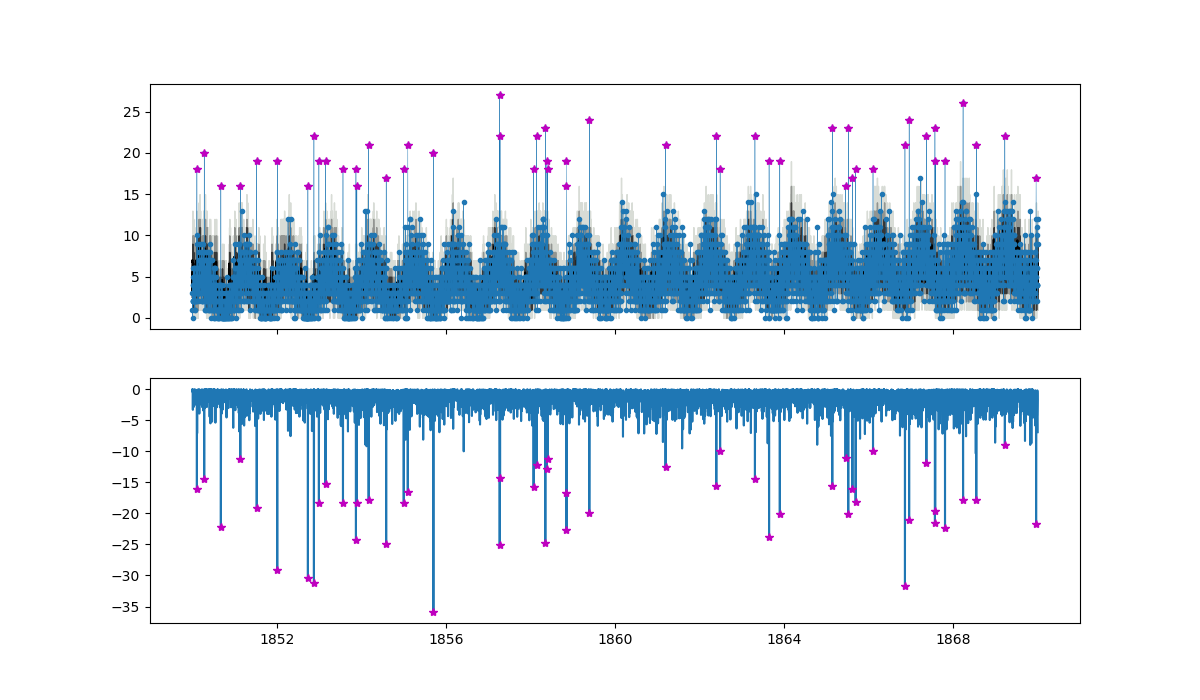

In [364]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,7))

ax.plot(curMean,'k')
ax.plot(curData,'.-',lw=0.3)
ax.plot(curData.iloc[indexToIncrease] ,'*m',lw=0.3)

ax.fill_between(curMean.index,curBot3,curTop3,color='xkcd:light gray')
ax.fill_between(curMean.index,curBot2,curTop2,color='xkcd:gray')
ax.fill_between(curMean.index,curBot1,curTop1,color='xkcd:dark gray')

# ax.plot(curMean.index,allMeans,lw=5)

ax2.plot(curSF)
ax2.plot(curSF.iloc[indexToIncrease] ,'*m')

In [187]:
# fig,(ax,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,7))

# ax.plot(curMean.iloc[::7])
# ax.plot(curData.iloc[::7],'.-',lw=0.3)
# ax.plot(curDataRaw.iloc[indexToIncrease]/7 ,'*m',lw=0.3)

# # ax.plot(curMean.index,allMeans,lw=5)

# ax2.plot(curSF.iloc[::7])
# # ax2.plot(curSF.iloc[indexToIncrease] ,'*m')